In [1]:
import tables
import pandas as pd
import numpy as np
import h5py
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy import stats
from iminuit import Minuit
import math
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import emcee
from scipy.constants import c
from scipy.special import erf
from scipy.stats import hypsecant
from scipy.stats import norm
from scipy.stats import laplace

from scipy.integrate import quad

from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.halo import mass_so
from colossus.halo import concentration
from scipy import interpolate
from intergrid.intergrid import Intergrid
%load_ext cython

In [2]:
# new../
# old ./
for i in tqdm(range(50)):
    filename='../Downloads/UM_2d-20220418T173722Z-001/UM_2d/new_mock_2d_'+str(i)+'.npy'
    d = np.load(filename)
    df=pd.DataFrame.from_records(d.tolist(), columns=d.dtype.names)
    if i==0: df2=df
    else: df2=df2.append(df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [3]:
df2=df2.reset_index(drop=True)
df2

,id,upid,x,y,z,vz,sm,sfr,icl,mp,...,hostr,rich_red_sp,mar,Vol,n,ainf,vravg,bin3d,bin,tag
0,10423006138,-1,4.031440,17.234131,91.366623,267.779999,1.265675e+12,1.576690,9.841825e+11,1.092859e+14,...,0.976222,31.0,0.287099,3.897041,1,0.3023,NaN,0,0,1
1,30000005231481032,10423006138,4.156453,16.853609,91.404953,-93.482491,7.514302e+10,0.072503,2.526506e+10,6.548751e+12,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,6,6,0
2,32000004879831165,10423006138,3.719872,17.296618,91.075821,-586.436646,3.497926e+10,0.075920,5.277254e+08,1.145720e+12,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,6,4,0
3,27000005764327304,10423006138,3.860375,17.180166,91.220757,-889.141663,6.465858e+10,0.107494,0.000000e+00,9.529140e+11,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,3,2,0
4,16000007722938411,10423006138,3.409460,17.631683,91.215752,165.205124,5.195008e+10,0.110130,0.000000e+00,8.070051e+11,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,11,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5135423,10560991948,10560991969,992.138794,938.410095,920.661682,672.460022,4.058310e+10,4.102032,2.483552e+09,4.131869e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,188.889977,17,12,0
5135424,10560991881,10560991969,993.139038,937.326721,920.917542,464.279999,3.443873e+10,0.027448,5.711738e+08,7.876229e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,608.097782,17,16,0
5135425,10560991965,10560991969,991.583252,938.003296,921.428833,532.679993,1.037432e+10,0.003338,7.785041e+08,3.407543e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,506.714590,14,14,0
5135426,10560992045,10560991969,992.953857,937.915161,921.393127,338.950012,9.276681e+09,0.033343,3.186511e+09,7.508916e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,139.517160,11,11,0


In [4]:
r_Mpc=df2.hostr*1e6 #Pc
G = 4.3009e-3 #M_solar^-1 pc (km/s)^2

In [5]:
df2['vcirc']=np.sqrt(G*df2.hostm/r_Mpc)

In [6]:
df2['justr']=df2.d2d*df2.hostr
df2['r_lambda']=(df2.rich_red_sp / 100.0) ** 0.2
df2['r_edge']=2.0*df2.hostr

In [9]:
N=50
intervals=np.logspace(np.log10(.2),np.log10(2),N)
center=(intervals[:-1]+intervals[1:])/2


In [10]:
Sigma_orb=[]
Sigma_inf=[]
Sigma_bg=[]
Sigma_orb_e=[]
Sigma_inf_e=[]
Sigma_bg_e=[]

for plt_idx in tqdm(range(0,len(intervals)-1)):
    minr=intervals[plt_idx]
    maxr=intervals[plt_idx+1]
    
    area=np.pi*(maxr**2-minr**2)
    dfcut=df2[ (df2.justr/df2.r_edge>minr) & (df2.justr/df2.r_edge<=maxr) & (df2.tag==0)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_orb=np.append(Sigma_orb,count/area)
    Sigma_orb_e=np.append(Sigma_orb_e,np.sqrt(count)/area)

    dfcut=df2[ (df2.justr/df2.r_edge>minr) & (df2.justr/df2.r_edge<=maxr) & (df2.tag==1)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_inf=np.append(Sigma_inf,count/area)
    Sigma_inf_e=np.append(Sigma_inf_e,np.sqrt(count)/area)

    dfcut=df2[ (df2.justr/df2.r_edge>minr) & (df2.justr/df2.r_edge<=maxr) & (df2.tag==2)].copy()
    dfcut=dfcut.reset_index()
    
    count=len(dfcut)
    Sigma_bg=np.append(Sigma_bg,count/area)
    Sigma_bg_e=np.append(Sigma_bg_e,np.sqrt(count)/area)

  0%|          | 0/49 [00:00<?, ?it/s]

In [11]:
from scipy.stats import linregress

x = center
y = np.log(Sigma_orb) 

orbreg = linregress(x, y)

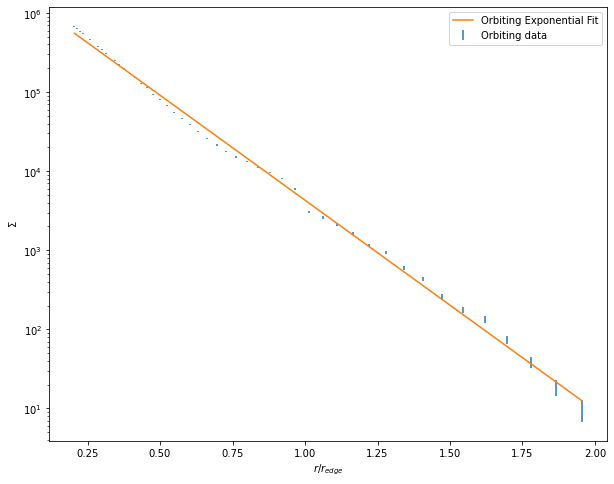

In [14]:
fig,(ax1) = plt.subplots(1, 1,figsize=(10,8))

#ax1.scatter(center,Sigma_orb, label='Universe Machine Data tagged as orbiting')
j=ax1.errorbar(center,Sigma_orb,Sigma_orb_e,linestyle='None', label='Orbiting data')
ax1.plot(center, np.exp(orbreg.intercept)*np.exp(center*orbreg.slope), label='Orbiting Exponential Fit')

ax1.legend()
ax1.set_xlabel('$r/r_{edge}$')
ax1.set_ylabel('$\Sigma$')
#ax1.set_xscale('log')
ax1.set_yscale('log')

In [35]:
orbreg.slope

-6.112998357436866

In [29]:
from scipy.stats import linregress

x = np.log(center)
y = np.log(Sigma_inf) 

infreg = linregress(x, y)

x = np.log(center)
y = np.log(Sigma_bg) 

bgreg = linregress(x, y)

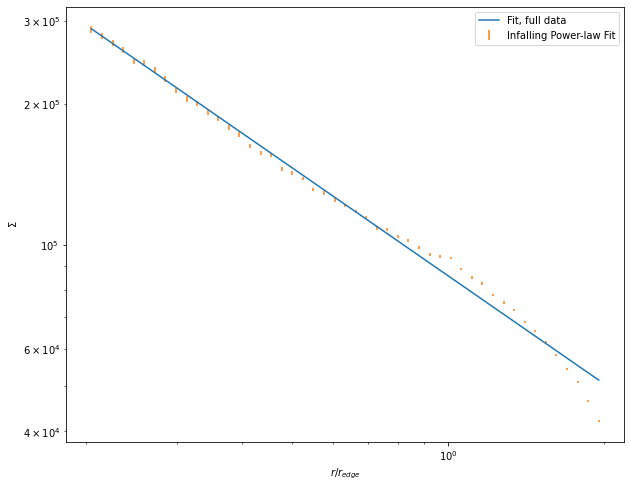

In [34]:
fig,(ax1) = plt.subplots(1, 1,figsize=(10,8))

ax1.plot(center, np.exp(infreg.intercept)*center**infreg.slope, label='Fit, full data')
j=ax1.errorbar(center,Sigma_inf,Sigma_inf_e,linestyle='None', label='Infalling Power-law Fit')

ax1.legend()
ax1.set_xlabel('$r/r_{edge}$')
ax1.set_ylabel('$\Sigma$')
#ax1.set_ylim([1e2,1e7])
ax1.set_xscale('log')
ax1.set_yscale('log')

In [28]:
np.exp(infreg.intercept)

73401.37542051473

In [29]:
infreg.slope

-0.7641214286005513

In [94]:
Sigma=pd.DataFrame({'r':center,'sigma_orb':Sigma_orb,'sigma_inf':Sigma_inf,'sigma_bg':Sigma_bg})

In [95]:
import pickle

output = open('Sigma.pkl', 'wb')
pickle.dump(Sigma, output)
output.close()